# Made by:
>Ramy Mohsen | 201900961

>Omar Emad    | 201901607

#Installs&Data

In [ ]:
!pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown '14U-es25AVmtD1pXM7xy1AD92L9z5gk-0'

Downloading...
From: https://drive.google.com/uc?id=14U-es25AVmtD1pXM7xy1AD92L9z5gk-0
To: /content/data_2.zip
100% 7.00M/7.00M [00:00<00:00, 109MB/s]


In [ ]:
!unzip './data_2.zip'

Archive:  ./data_2.zip
replace data_2/EpiscopalGaudi/EGaudiEval.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Imports

In [ ]:
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from skimage import io, img_as_float32
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.feature import plot_matches, peak_local_max
from skimage.filters import sobel_h, sobel_v, scharr_h, scharr_v, gaussian
from skimage.measure import regionprops
from typing import List
import scipy.io as scio
import os
import memory_profiler
import scipy.spatial

#Code

##Visualize

In [ ]:
def show_correspondences(imgA, imgB, X1, Y1, X2, Y2, matches, good_matches, number_to_display, filename=None):
	"""
		Visualizes corresponding points between two images, either as
		arrows or dots

		mode='dots': Corresponding points will have the same random color
		mode='arrows': Corresponding points will be joined by a line

		Writes out a png of the visualization if 'filename' is not None.
	"""

	# generates unique figures so students can
	# look at all three at once
	fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,15))

	matches = matches[0:number_to_display, :]
	good_matches = good_matches[0:number_to_display]

	kp1 = zip_x_y(Y1, X1)
	kp2 = zip_x_y(Y2, X2)
	matches = matches.astype(int)
	plot_matches(ax, imgA, imgB, kp1, kp2, matches[np.logical_not(good_matches)], matches_color='orangered')
	plot_matches(ax, imgA, imgB, kp1, kp2, matches[good_matches], matches_color='springgreen')

	fig = plt.gcf()
	if filename:
		if not os.path.isdir('../results'):
			os.mkdir('../results')
		fig.savefig('../results/' + filename)
	plt.show()



def zip_x_y(x, y):
	zipped_points = []
	for i in range(len(x)):
		zipped_points.append(np.array([x[i], y[i]]))
	return np.array(zipped_points)

def plot_figure(image_list: List[np.ndarray], title_list: List[str], height, width):
    assert len(image_list) == len(title_list)
    for i in range(len(image_list)):
        plt.subplot(height, width, i + 1), plt.imshow(image_list[i], 'gray')
        plt.title(title_list[i])
        plt.xticks([]), plt.yticks([])
    plt.show()

##Helpers

In [ ]:
# A set of helpers which are useful for debugging SIFT!
# Feel free to take a look around in case you are curious,
# but you shouldn't need to know exactly what goes on,
# and you certainly don't need to change anything

def memfunc():
    # Note: these files default to notre dame, unless otherwise specified
    image1_file = "./data_2/NotreDame/NotreDame1.jpg"
    image2_file = "./data_2/NotreDame/NotreDame2.jpg"
    eval_file = "./data_2/NotreDame/NotreDameEval.mat"

    scale_factor = 0.5
    feature_width = 16

    image1 = img_as_float32(rescale(rgb2gray(io.imread(image1_file)), scale_factor))
    image2 = img_as_float32(rescale(rgb2gray(io.imread(image2_file)), scale_factor))

    (x1, y1, sigma1) = get_interest_points(image1, feature_width)
    (x2, y2, sigma2) = get_interest_points(image2, feature_width)

    image1_features = get_features(image1, x1, y1, sigma1, feature_width)
    image2_features = get_features(image2, x2, y2, sigma2, feature_width)

    matches, confidences = match_features(image1_features, image2_features)

    evaluate_correspondence(image1, image2, eval_file, scale_factor,
                            x1, y1, x2, y2, matches, confidences, 0)
    return

# Gives you the TA solution for the interest points you
# should find
def cheat_interest_points(eval_file, scale_factor):
    file_contents = scio.loadmat(eval_file)

    x1 = file_contents['x1']
    y1 = file_contents['y1']
    x2 = file_contents['x2']
    y2 = file_contents['y2']

    x1 = x1 * scale_factor
    y1 = y1 * scale_factor
    x2 = x2 * scale_factor
    y2 = y2 * scale_factor

    x1 = x1.reshape(-1)
    y1 = y1.reshape(-1)
    x2 = x2.reshape(-1)
    y2 = y2.reshape(-1)

    return x1, y1, x2, y2


def estimate_fundamental_matrix(Points_a, Points_b):
    # Get linear system of eqns
    # each row will be:
    # [u'u u'v u' v'u v'v v' u v 1]
    # found from rearranging the defn of the fundamental matrix
    # we assume the prime image is image B

    n = Points_b.shape[0]
    u_prime = np.copy(Points_b[:, 0])
    v_prime = np.copy(Points_b[:, 1])
    u = np.copy(Points_a[:, 0])
    v = np.copy(Points_a[:, 1])

    ############################
    # Normalize points
    # Calculate offset matrices combining images a and b
    c_u = np.mean(u)
    c_v = np.mean(v)
    c_u_prime = np.mean(u_prime)
    c_v_prime = np.mean(v_prime)

    offset_matrix = np.array([[1, 0, -c_u], [0, 1, -c_v], [0, 0, 1]])
    offset_matrix_prime = np.array([[1, 0, -c_u_prime], [0, 1, -c_v_prime], [0, 0, 1]])

    # Calculate scale matrices for images a and b
    s = 1 / np.std([[u - c_u], [v - c_v]])
    s_prime = 1 / np.std([[u_prime - c_u_prime], [v_prime - c_v_prime]])

    scale_matrix = np.array([[s, 0, 0], [0, s, 0], [0, 0, 1]])
    scale_matrix_prime = np.array([[s_prime, 0, 0], [0, s_prime, 0], [0, 0, 1]])

    T_a = scale_matrix @ offset_matrix
    T_b = scale_matrix_prime @ offset_matrix_prime

    # Normalize points from images a and b
    for i in range(0, n):
        norm = T_a @ np.transpose([u[i], v[i], 1])
        norm_prime = T_b @ np.transpose([u_prime[i], v_prime[i], 1])
        u[i] = norm[0]
        v[i] = norm[1]
        u_prime[i] = norm_prime[0]
        v_prime[i] = norm_prime[1]

    # Normalize points ends here
    ############################

    # create data matrix
    data_matrix = np.array([u_prime * u, u_prime * v, u_prime,
                            v_prime * u, v_prime * v, v_prime,
                            u, v, np.ones((n))])
    data_matrix = np.transpose(data_matrix)

    # Get system matrix using svd
    U, S, Vh = np.linalg.svd(data_matrix)

    # Get column of V coresp to the smallest singular value for full rank F
    # Note: np.linalg.svd returns the transpose of V (Vh), so we take the last row instead of the last column
    # Vh is sorted in descending order of the size of the eigenvalues
    # indx = np.argmin(S)
    # full_F = Vh[indx,:]
    full_F = Vh[-1, :]

    # Reshape column to 3x3 so we have the right dimension for F
    full_F = np.reshape(full_F, (3, 3))
    # print(np.linalg.matrix_rank(full_F))

    # Reduce rank to get final F
    # Note: np.linalg.svd returns the transpose of V (Vh), so we don't have to transpose it here.
    # for the matrix multiplication to produce F_matrix
    U, S, Vh = np.linalg.svd(full_F)
    # S is sorted in descending order of the size of the eigenvalues
    # indx = np.argmin(S)
    # S[indx] = 0
    S[-1] = 0
    F_matrix = U @ np.diagflat(S) @ Vh
    # print(np.linalg.matrix_rank(F_matrix))

    # Adjust back to original coordinates
    F_matrix = np.transpose(T_b) @ F_matrix @ T_a
    return F_matrix


def evaluate_correspondence(img_A, img_B, ground_truth_correspondence_file,
                            scale_factor, x1_est, y1_est, x2_est, y2_est, matches, confidences, vis,
                            filename="notre_dame_matches.jpg"):
    # 'unscale' interest points to compare with ground truth points
    x1_est_scaled = x1_est / scale_factor
    y1_est_scaled = y1_est / scale_factor
    x2_est_scaled = x2_est / scale_factor
    y2_est_scaled = y2_est / scale_factor

    conf_indices = np.argsort(-confidences, kind='mergesort')
    matches = matches[conf_indices, :]
    confidences = confidences[conf_indices]

    # we want to see how good our matches are, extract the coordinates of each matched
    # point

    x1_matches = np.zeros(matches.shape[0])
    y1_matches = np.zeros(matches.shape[0])
    x2_matches = np.zeros(matches.shape[0])
    y2_matches = np.zeros(matches.shape[0])

    for i in range(matches.shape[0]):
        x1_matches[i] = x1_est_scaled[int(matches[i, 0])]
        y1_matches[i] = y1_est_scaled[int(matches[i, 0])]
        x2_matches[i] = x2_est_scaled[int(matches[i, 1])]
        y2_matches[i] = y2_est_scaled[int(matches[i, 1])]

    good_matches = np.zeros((matches.shape[0]), dtype=bool)

    # Loads `ground truth' positions x1, y1, x2, y2
    file_contents = scio.loadmat(ground_truth_correspondence_file)

    # x1, y1, x2, y2 = scio.loadmat(eval_file)
    x1 = file_contents['x1']
    y1 = file_contents['y1']
    x2 = file_contents['x2']
    y2 = file_contents['y2']

    pointsA = np.zeros((len(x1), 2))
    pointsB = np.zeros((len(x2), 2))

    for i in range(len(x1)):
        pointsA[i, 0] = x1[i]
        pointsA[i, 1] = y1[i]
        pointsB[i, 0] = x2[i]
        pointsB[i, 1] = y2[i]

    correct_matches = 0

    F = estimate_fundamental_matrix(pointsA, pointsB)
    top50 = 0
    top100 = 0

    for i in range(x1_matches.shape[0]):
        pointA = np.ones((1, 3))
        pointB = np.ones((1, 3))
        pointA[0, 0] = x1_matches[i]
        pointA[0, 1] = y1_matches[i]
        pointB[0, 0] = x2_matches[i]
        pointB[0, 1] = y2_matches[i]

        if abs(pointB @ F @ np.transpose(pointA)) < .1:
            x_dists = x1 - x1_matches[i]
            y_dists = y1 - y1_matches[i]

            # computes distances of each interest point to the ground truth point
            dists = np.sqrt(np.power(x_dists, 2.0) + np.power(y_dists, 2.0))
            closest_ground_truth = np.argmin(dists, axis=0)
            offset_x1 = x1_matches[i] - x1[closest_ground_truth]
            offset_y1 = y1_matches[i] - y1[closest_ground_truth]
            offset_x1 *= img_B.shape[0] / img_A.shape[0]
            offset_y1 *= img_B.shape[0] / img_A.shape[0]
            offset_x2 = x2_matches[i] - x2[closest_ground_truth]
            offset_y2 = y2_matches[i] - y2[closest_ground_truth]
            offset_dist = np.sqrt(np.power(offset_x1 - offset_x2, 2) + np.power(offset_y1 - offset_y2, 2))
            if offset_dist < 70:
                correct_matches += 1
                good_matches[i] = True
        if i == 49:
            print(f'Accuracy on 50 most confident: {int(100 * correct_matches / 50)}%')
            top50 = correct_matches
        if i == 99:
            print(f'Accuracy on 100 most confident: {int(100 * correct_matches / 100)}%')
            top100 = correct_matches

    print(f'Accuracy on all matches: {int(100 * correct_matches / len(matches))}%')

    if vis > 0:
        print("Vizualizing...")
        show_correspondences(img_A, img_B, x1_est / scale_factor, y1_est / scale_factor,
                                       x2_est / scale_factor, y2_est / scale_factor, matches, good_matches, vis,
                                       filename)

    return top50, top100, correct_matches


##Main

In [ ]:
# Local Feature Stencil Code
# Written by James Hays for CS 143 @ Brown / CS 4476/6476 @ Georgia Tech with Henry Hu <henryhu@gatech.edu>
# Edited by James Tompkin
# Adapted for python by asabel and jdemari1 (2019)

# This script
# (1) Loads and resizes images
# (2) Finds interest points in those images                 (you code this)
# (3) Describes each interest point with a local feature    (you code this)
# (4) Finds matching features                               (you code this)
# (5) Visualizes the matches
# (6) Evaluates the matches based on ground truth correspondences

def load_data(file_name):
    """
     1) Load stuff
     There are numerous other image sets in the supplementary data on the
     project web page. You can simply download images off the Internet, as
     well. However, the evaluation function at the bottom of this script will
     only work for three particular image pairs (unless you add ground truth
     annotations for other image pairs). It is suggested that you only work
     with the two Notre Dame images until you are satisfied with your
     implementation and ready to test on additional images. A single scale
     pipeline works fine for these two images (and will give you full credit
     for this project), but you will need local features at multiple scales to
     handle harder cases.

     If you want to add new images to test, create a new elif of the same format as those
     for notre_dame, mt_rushmore, etc. You do not need to set the eval_file variable unless
     you hand create a ground truth annotations. To run with your new images use
     python main.py -p <your file name>.

    :param file_name: string for which image pair to compute correspondence for

        The first three strings can be used as shortcuts to the
        data files we give you

        1. notre_dame
        2. mt_rushmore
        3. e_gaudi

    :return: a tuple of the format (image1, image2, eval file)
    """

    # Note: these files default to notre dame, unless otherwise specified
    image1_file = "./data_2/NotreDame/NotreDame1.jpg"
    image2_file = "./data_2/NotreDame/NotreDame2.jpg"

    eval_file = "./data_2/NotreDame/NotreDameEval.mat"

    if file_name == "notre_dame":
        pass
    elif file_name == "mt_rushmore":
        image1_file = "./data_2/MountRushmore/Mount_Rushmore1.jpg"
        image2_file = "./data_2/MountRushmore/Mount_Rushmore2.jpg"
        eval_file = "./data_2/MountRushmore/MountRushmoreEval.mat"
    elif file_name == "e_gaudi":
        image1_file = "./data_2/EpiscopalGaudi/EGaudi_1.jpg"
        image2_file = "./data_2/EpiscopalGaudi/EGaudi_2.jpg"
        eval_file = "./data_2/EpiscopalGaudi/EGaudiEval.mat"

    image1 = img_as_float32(io.imread(image1_file))
    image2 = img_as_float32(io.imread(image2_file))

    return image1, image2, eval_file


def main(pair, feature_width):
    """

    Reads in the data,

    Command line usage: python main.py -p | --pair <image pair name>

    -p | --pair - flag - required. specifies which image pair to match

    """

    # (1) Load in the data
    image1_color, image2_color, eval_file = load_data(pair)

    image1 = rgb2gray(image1_color)
    image2 = rgb2gray(image2_color)

    # Our own rgb2gray coefficients which match Rec.ITU-R BT.601-7 (NTSC) luminance conversion
    #image1 = image1_color[:,:,0] * 0.2989 + image1_color[:,:, 1] * 0.5870 + image1_color[:,:,2] * 0.1140
    #image2 = image2_color[:,:,0] * 0.2989 + image2_color[:,:,1] * 0.5870 + image2_color[:,:,2] * 0.1140

    scale_factor = 0.5

    # Bilinear rescaling
    image1 = np.float32(rescale(image1, scale_factor))
    image2 = np.float32(rescale(image2, scale_factor))

    # width and height of each local feature, in pixels
    # feature_width = 16

    # (2) Find distinctive points in each image. See Szeliski 4.1.1
    stt=time.time()
    print("Getting interest points...")

    st=time.time()
    (x1, y1) = get_interest_points(image1, feature_width)
    (x2, y2) = get_interest_points(image2, feature_width)

    #(x1, y1, x2, y2) = cheat_interest_points(eval_file, scale_factor)
    ed=time.time()
    print(f"Time Taken To Get Interest Points {ed-st:.2f} Seconds")
    #plt.figure(figsize=(10,10))
    #plt.imshow(image1, cmap="gray")
    #plt.scatter(x1, y1, c=['red'], alpha=0.9, s=5)
    #plt.show()

    #plt.figure(figsize=(10,10))
    #plt.imshow(image2, cmap="gray")
    #plt.scatter(x2, y2, alpha=0.9, s=3)
    #plt.show()

    print("Done!\n")

    # 3) Create feature vectors at each interest point. Szeliski 4.1.2

    print("Getting features...")
    st=time.time()
    image1_features = get_features(image1, x1, y1, feature_width)
    image2_features = get_features(image2, x2, y2, feature_width)

    ed=time.time()
    print(f"Time Taken To Get Features {ed-st:.2f} Seconds")
    print("Done!\n")

    # 4) Match features. Szeliski 4.1.3

    print("Matching features...")
    st=time.time()

    matches, confidences = match_features(image1_features, image2_features)

    ed=time.time()
    print(f"Time Taken To Match Features {ed-st:.2f} Seconds")
    print("Done!\n")
    edt=time.time()
    print(f"Total Time Taken {(edt-stt)/60:.2f} Minutes")
    # 5) Evaluation and visualization

    # The last thing to do is to check how your code performs on the image pairs
    # we've provided. The evaluate_correspondence function below will print out
    # the accuracy of your feature matching for your 50 most confident matches,
    # 100 most confident matches, and all your matches. It will then visualize
    # the matches by drawing green lines between points for correct matches and
    # red lines for incorrect matches. The visualizer will show the top
    # num_pts_to_visualize most confident matches, so feel free to change the
    # parameter to whatever you like.

    print("Matches: " + str(matches.shape[0]))

    num_pts_to_visualize = 50

    evaluate_correspondence(image1_color, image2_color, eval_file, scale_factor,
                            x1, y1, x2, y2, matches, confidences,
                            num_pts_to_visualize, pair + '_matches.jpg')

##Student

In [ ]:
def my_harris(img, win_size=16, ks=5, alpha=0.06):
    """
    :params:
    :img: a grayscale
    :win_size: the window around which we calculate the Harris response function
    :ks: for sobel
    :alpha: to calcuate Harris response function

    :returns:
    :corners: a 2D np array of corner locations
    """
    win_size = int(win_size/2)
    corners = np.zeros(img.shape)
    Rs = np.zeros(img.shape)
    xs = []
    ys = []
    stride = 1

    edge_x = cv2.Sobel(img, cv2.CV_8U,  1, 0, ksize=ks)
    edge_y = cv2.Sobel(img, cv2.CV_8U,  0, 1, ksize=ks)

    Ix = gaussian(edge_x, 0.2)
    Iy = gaussian(edge_y, 0.2)

    Ixx = Ix**2
    Ixy = Iy*Ix
    Iyy = Iy**2

    n, m = img.shape

    for i in range(win_size, n-win_size, stride):
      for j in range(win_size, m-win_size, stride):
        #Compute the Harris matrix H in a window around each pixel
        Sxx = np.sum(Ixx[i-win_size:i+win_size, j-win_size:j+win_size])
        Syy = np.sum(Iyy[i-win_size:i+win_size, j-win_size:j+win_size])
        Sxy = np.sum(Ixy[i-win_size:i+win_size, j-win_size:j+win_size])
        #Find determinant and trace, use to get corner response
        detH = (Sxx * Syy) - (Sxy**2)
        TriH = Sxx + Syy
        Rs[i, j] = detH - alpha*(TriH**2)

    return Rs

In [ ]:
def get_interest_points(image, feature_width):
    """
    :params:
    :image: a grayscale or color image (your choice depending on your implementation)
    :feature_width:

    :returns:
    :xs: an np array of the x coordinates of the interest points in the image
    :ys: an np array of the y coordinates of the interest points in the image

    :optional returns (may be useful for extra credit portions):
    :confidences: an np array indicating the confidence (strength) of each interest point
    :scale: an np array indicating the scale of each interest point
    :orientation: an np array indicating the orientation of each interest point
    """


    Rs = my_harris(image, win_size=feature_width, ks=5, alpha=0.06)
    Rs *= (Rs > 0.0005).astype(np.float32)
    xs = []
    ys = []

    # non-max suppersion with a X.X window
    coordinates = peak_local_max(Rs, min_distance=2)
    ys, xs = coordinates[:, 0], coordinates[:, 1]

    #ys, xs = Rs.nonzero()

    print(f"{np.array(xs).shape[0]} Interest Points Found !\n")

    return np.array(xs), np.array(ys)

In [ ]:
def get_features(image, x, y, feature_width):
    """
    :params:

    :image: a grayscale or color image (your choice depending on your implementation)
    :x: np array of x coordinates of interest points
    :y: np array of y coordinates of interest points
    :feature_width: in pixels, is the local feature width. You can assume
                    that feature_width will be a multiple of 4 (i.e. every cell of your
                    local SIFT-like feature will have an integer width and height).

    :returns:

    :features: np array of computed features. It should be of size
            [len(x) * feature dimensionality] (for standard SIFT feature
            dimensionality is 128)
    """
    # create placeholder for features
    no_bins=8
    features = np.zeros((len(x),int(feature_width/4), int(feature_width/4), no_bins))

    # apply gaussian before getting edges
    L = gaussian(image, 1.7)

    # we tried sobel but its values were too low
    edge_x = scharr_v(L)
    edge_y = scharr_h(L)

    # calc magnitudes
    grads = (edge_x**2 + edge_y**2)**0.5

    # calc phases
    phases = np.rad2deg(np.arctan2(edge_y, edge_x))

    # in case of negative angles
    phases += 360*((phases<0).astype(np.float32))

    #window size, the feature_widthxfeature_width
    ws = int(feature_width/2)

    #sub window size, the 4x4
    sws = 4

    for i in range(len(x)):
      # get the a window around keypoint of size feature_widthxfeature_width
      curr_win_grads  = grads [int(y[i]) - ws:int(y[i]) + ws, int(x[i]) - ws:int(x[i]) + ws]
      curr_win_phases = phases[int(y[i]) - ws:int(y[i]) + ws, int(x[i]) - ws:int(x[i]) + ws]

      # disect window into 4x4 small blocks
      for l in range(int(feature_width/4)):
        for k in range(int(feature_width/4)):
          curr_Subwin_phases = curr_win_phases[l*sws:(l+1)*sws,  k*sws:(k+1)*sws].flatten()
          curr_Subwin_grads  = curr_win_grads [l*sws:(l+1)*sws,  k*sws:(k+1)*sws].flatten()
          features[i,l,k] = np.histogram(curr_Subwin_phases, bins=no_bins, range=(0, 360), weights = curr_Subwin_grads)[0]

    # reshape to a vector of (keypoints, 4x4x8)
    features = features.reshape((len(x), -1))
    #calc norms to normalize
    norms = np.linalg.norm(features, axis=1).reshape(-1, 1)

    # set zero norms to 1 to avoid nans
    norms[norms == 0] = 1

    features = features / norms

    # clip to values to some number
    features[features >= 0.2] = 0.2

    #normalize again
    norms = np.linalg.norm(features, axis=1).reshape(-1, 1)

    # set zero norms to 1 to avoid nans
    norms[norms == 0] = 1

    features = features / norms
    # set to a a power
    features  = features ** 0.7

    return features

In [ ]:
def match_features(F1, F2):
    """
    https://cs.brown.edu/courses/csci1430/2021_Spring/proj2_featurematching/matching/

    :params:
    :im1_features: an np array of features returned from get_features() for interest points in image1
    :im2_features: an np array of features returned from get_features() for interest points in image2

    :returns:
    :matches: an np array of dimension k x 2 where k is the number of matches. The first
            column is an index into im1_features and the second column is an index into im2_features
    :confidences: an np array with a real valued confidence for each match
    """
    #D = sqrt(||F1||^2 + ||F1||^2 -2.F1.F2^T)
    Norm_F1 = np.sum(np.array(F1)**2, axis=1).reshape(-1,1)
    Norm_F2 = np.sum(np.array(F2)**2, axis=1).reshape(1,-1)

    # singleton expansion
    A = Norm_F1 + Norm_F2
    B = 2*np.matmul(F1, np.transpose(F2))

    # now we have calculated the euclidean distance between each feature vector in F1 and all feature vectors in F2
    D = np.sqrt(A-B)

    matches = []
    confidences = []

    threshhold = 0.8
    for f in range(len(F1)):
      #get indices of nearsest two
      indices = np.argsort(D[f,:])[:2]
      B, C = indices
      D1 = D[f,B]
      D2 = D[f,C]
      NNDR = D1/D2
      if NNDR < threshhold:
        matches.append([f,B])
        #the lower confidence the closer we are to the threshhold
        #thus if we are very close to threshold then it means this is probably a "meh" match
        confidences.append(100-((NNDR)/threshhold)*100)

    return np.array(matches), np.array(confidences)

#Testing

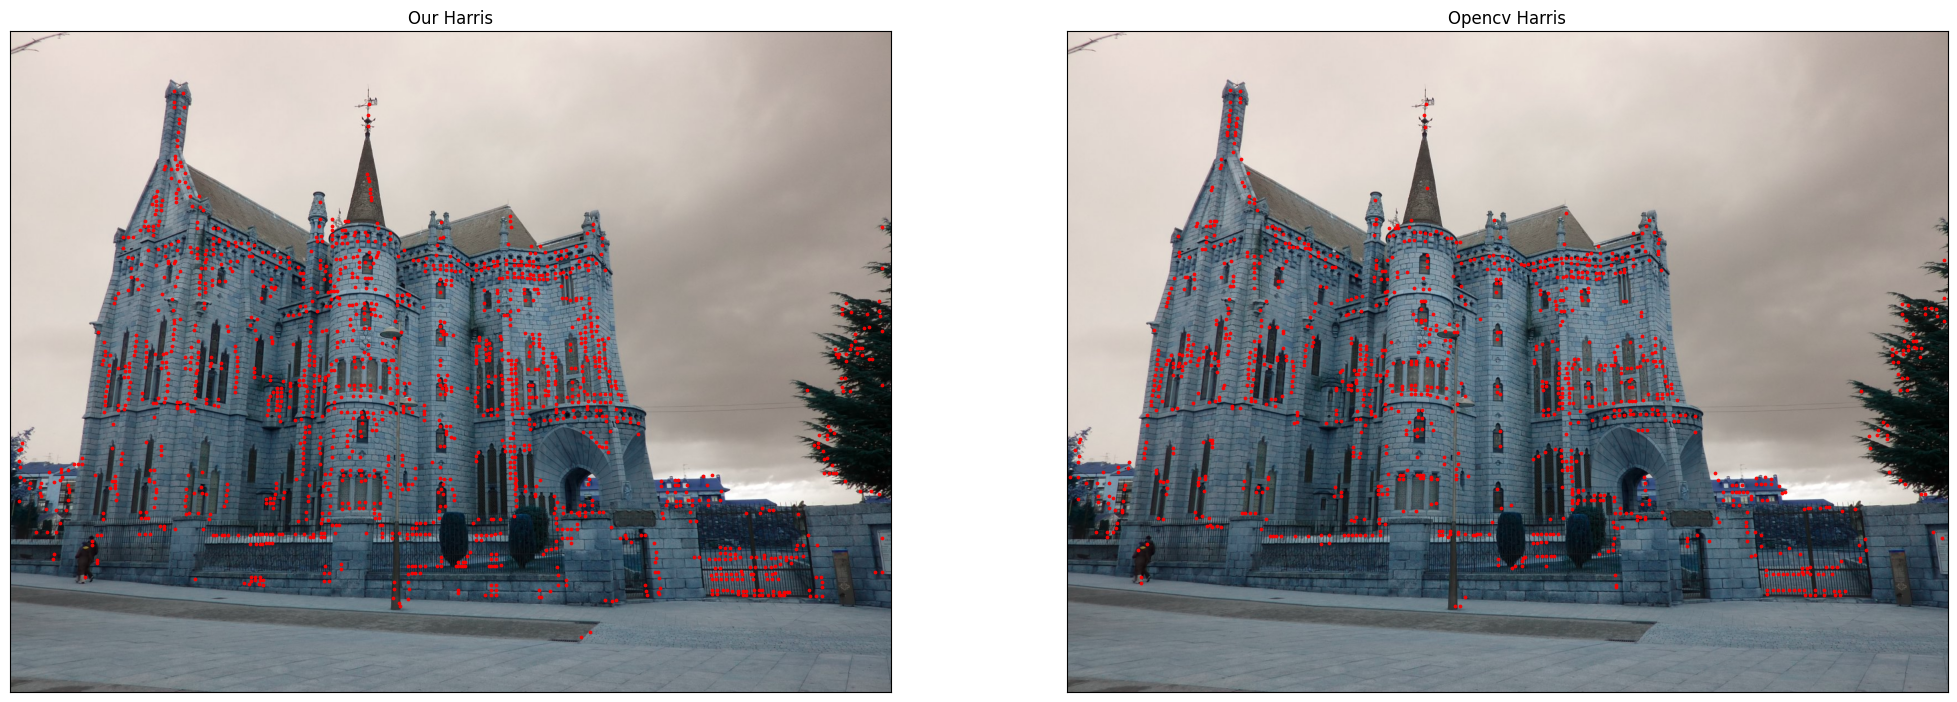

In [ ]:
img = cv2.imread('/content/data_2/EpiscopalGaudi/EGaudi_1.jpg')
image2 = rgb2gray(img)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,25))

ax[0].imshow(img)
ax[1].imshow(img)

img_my_harris = my_harris(image2, 32, 7, 0.06)
opencv_my_harris = cv2.cornerHarris(img_as_float32(image2), 32, 7, 0.06)

# threshhold
img_my_harris    *= (img_my_harris    > 0.01*img_my_harris.max()).astype(np.float32)
opencv_my_harris *= (opencv_my_harris > 0.01*opencv_my_harris.max()).astype(np.float32)

# apply non max suppersion to refine the details of corners
coordinates = peak_local_max(img_my_harris, min_distance=3)
ys, xs = coordinates[:, 0], coordinates[:, 1]
ax[0].scatter(xs, ys, c=['red'], alpha=0.9, s=3)

coordinates = peak_local_max(opencv_my_harris, min_distance=3)
ys, xs = coordinates[:, 0], coordinates[:, 1]
ax[1].scatter(xs, ys, c=['red'], alpha=0.9, s=3)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])


ax[0].title.set_text("Our Harris")
ax[1].title.set_text("Opencv Harris")

plt.show()

Getting interest points...
1627 Interest Points Found !

1966 Interest Points Found !

Time Taken To Get Interest Points 13.56 Seconds
Done!

Getting features...
Time Taken To Get Features 26.25 Seconds
Done!

Matching features...
Time Taken To Match Features 0.35 Seconds
Done!

Total Time Taken 0.67 Minutes
Matches: 121
Accuracy on 50 most confident: 100%
Accuracy on 100 most confident: 100%
Accuracy on all matches: 99%
Vizualizing...


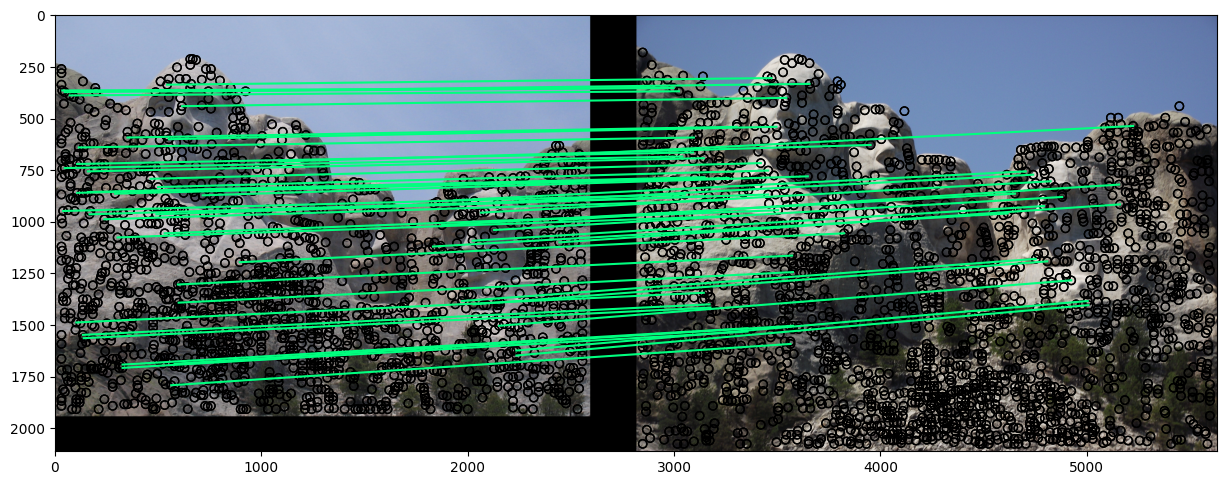

In [ ]:
feature_width = 32
############## best params(so far) #############
########### get_interest_points
#sobel 7, thresh 0.01, alpha=0.04, harris stride 2, Non-max with win of 4

########### get_features
#sigma 1.6, 0.20 clip, feature**0.8

main('mt_rushmore',feature_width)

Getting interest points...
2225 Interest Points Found !

1813 Interest Points Found !

Time Taken To Get Interest Points 7.57 Seconds
Done!

Getting features...
Time Taken To Get Features 32.92 Seconds
Done!

Matching features...
Time Taken To Match Features 0.42 Seconds
Done!

Total Time Taken 0.68 Minutes
Matches: 70
Accuracy on 50 most confident: 96%
Accuracy on all matches: 91%
Vizualizing...


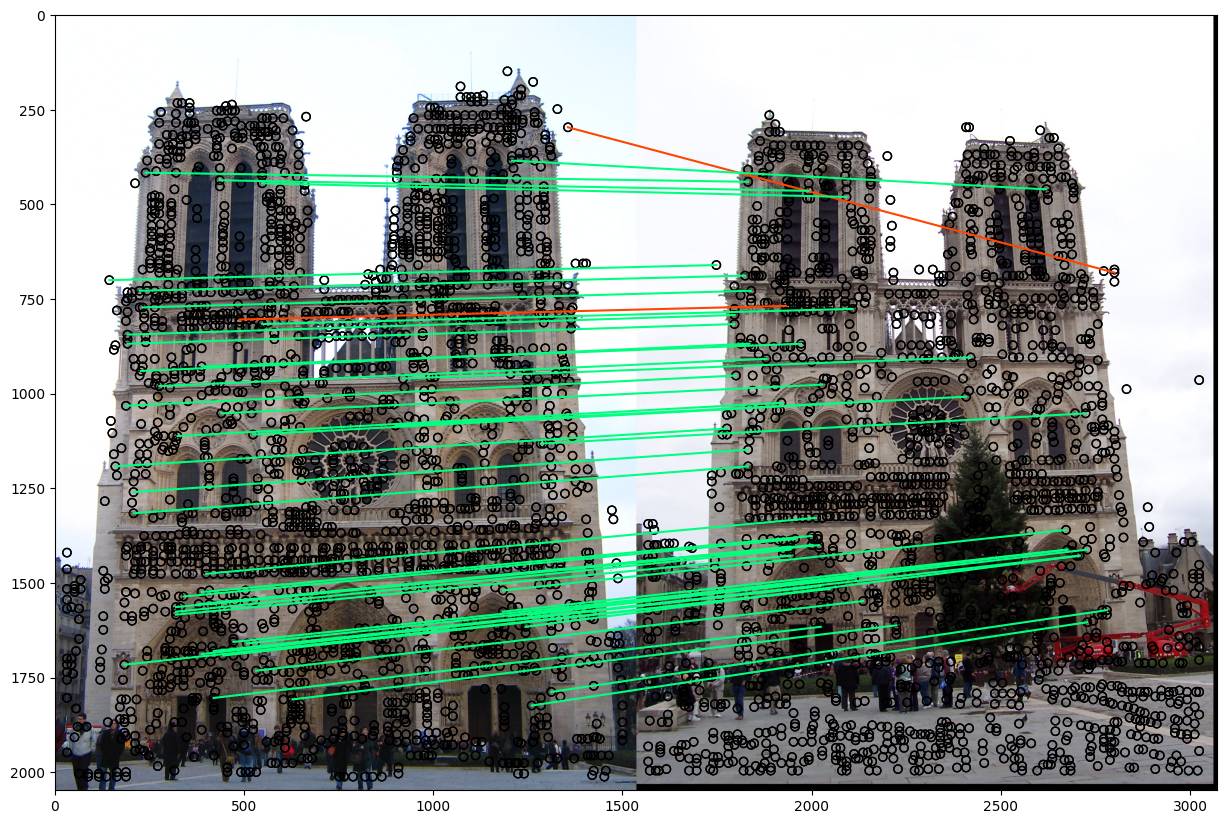

In [ ]:
feature_width = 32
############## best params(so far) #############
########### get_interest_points
#sobel 7, thresh 0.01, alpha=0.05, harris stride 2, Non-max with win of 3

########### get_features
#sigma 1.6, 0.2 clip, feature**0.8

main('notre_dame', feature_width)

Getting interest points...
960 Interest Points Found !

3712 Interest Points Found !

Time Taken To Get Interest Points 8.68 Seconds
Done!

Getting features...
Time Taken To Get Features 34.87 Seconds
Done!

Matching features...
Time Taken To Match Features 0.40 Seconds
Done!

Total Time Taken 0.73 Minutes
Matches: 2
Accuracy on all matches: 100%
Vizualizing...


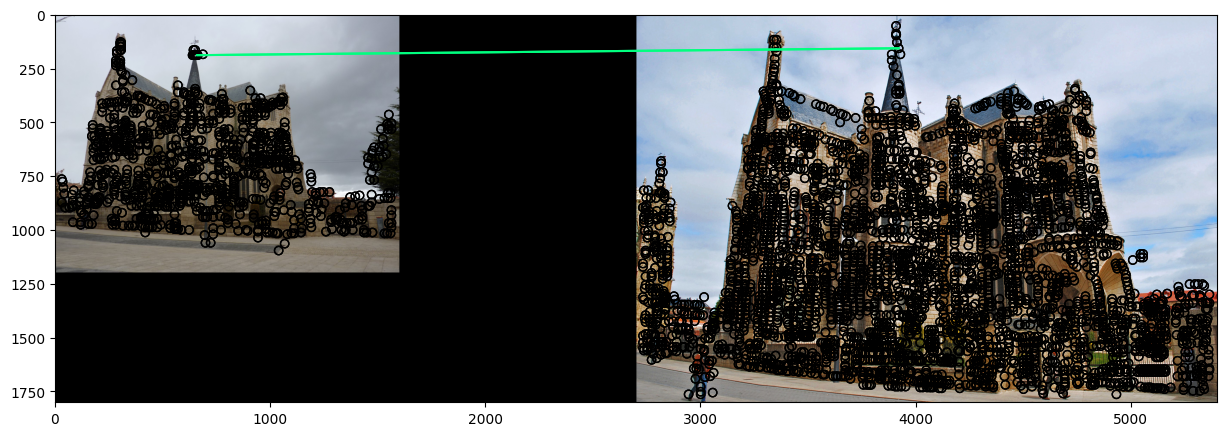

In [ ]:
feature_width = 32
############## best params(so far) #############
########### get_interest_points
#sobel 5, thresh 0.0005, alpha=0.06, harris stride 2, Non-max with win of 2

########### get_features
#sigma 1.7, 0.20 clip, feature**0.7

main('e_gaudi',feature_width)